## Construct a potential from a custom density function

We need to create potentials for these two distributions:

![images/pic1.png](images/pic1.png)

Dark matter density – dashed line, black hole density – dotted line

We assume that all $N$ particles have the same mass: $m = M_{☉}$. This is just a toy example based on https://arxiv.org/pdf/1807.06590

In [1]:
# imports
import math
from functools import partial

import agama
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

# choose the best units for this task
agama.setUnits(
    length=0.001, mass=1, velocity=1
)  # length in pc, mass in solar mass, velocity in km/s
agama.G

0.00430091727067736

Assymptotically these potentials look as follows:

- Potential for black hole: $\rho_{BH}(r)[M_{☉}\times pc^{-3}] \sim e^{4.5} \times r[pc]^{-2.8}$
- Potential for dark matter: $\rho_{DM}(r)[M_{☉}\times pc^{-3}] \sim e^{5} \times r[pc]^{-2.1}$

To get the final formula we need to take these two things into account:

1. We need to multiply $\rho$ by the exponent $e^{-r/r_{cutoff}}[pc]$, otherwise $\int_{0}^{\infty} \rho(r) \,d^3r$ will not converge. The choise of $r_{cutoff}$ is arbitrary, let's use $r_{cutoff} = 10 [pc]$ (or even make $r_{cutoff}$ the parameter of a density function).
1. Also we need to introduce a very small $r_0$ — one more parameter of a density function. At distances $r < r_0$ the density function should become a constant. Otherwise $\rho(r)$ and $\Phi(r)$ will diverge at $r=0$.

Finally, our potentials are:
$$\rho_{BH}(r) = \frac{e^{4.5} \times e^{-r/r_{cutoff}}}{\sqrt{r^2 + r_0^2}^{2.8}}$$
$$\rho_{DM}(r) = \frac{e^{5} \times e^{-r/r_{cutoff}}}{\sqrt{r^2 + r_0^2}^{2.1}} $$

In [2]:
# Choose default density parameters
r0 = 5e-3  # in pc
rcut = 10  # in pc too

def dist(xyz, r0=r0):
    return np.sqrt(np.sum(xyz**2, axis=1) + r0**2)


def rho_bh(xyz, r0=r0, rcut=rcut):
    r = dist(xyz, r0=r0)
    return np.e**4.5 * r ** (-2.8) * np.e ** (-r / rcut)


def rho_dm(xyz, r0=r0, rcut=rcut):
    r = dist(xyz, r0=r0)
    return np.e**5 * r ** (-2.1) * np.e ** (-r / rcut)

In [3]:
def plot_densities(f_bh, f_dm):
    r = np.logspace(-4, 1)
    xyz = np.vstack((r, r * 0, r * 0)).T
    
    plt.plot(r, f_bh(xyz), linestyle="dotted", label="BH, $r^{-2.8}$")
    plt.plot(r, f_dm(xyz), linestyle="dashed", label="DM, $r^{-2.1}$")
    
    plt.xlabel("r")
    plt.ylabel(r"$\rho$")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-4, 1e1)
    plt.ylim(1e2, 1e16)

    plt.legend()

Let's plot $\rho(r)$ just to make sure it looks okay:

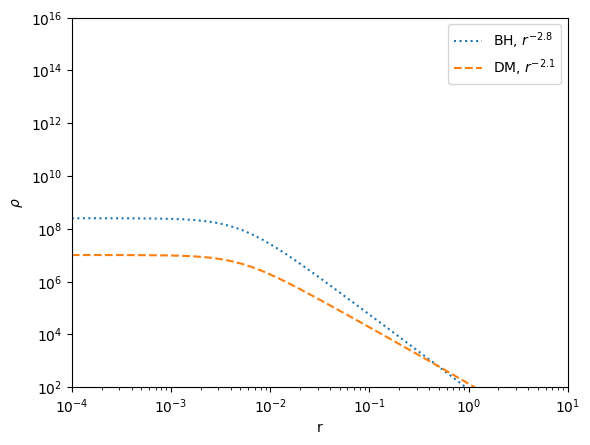

In [4]:
plot_densities(rho_bh, rho_dm)

Create potentials

In [5]:
potential_bh = agama.Potential(
    type="Multipole", density=rho_bh, symmetry="s"
)
potential_dm = agama.Potential(
    type="Multipole", density=rho_dm, symmetry="s"
)

In [6]:
df_bh = agama.DistributionFunction(type="QuasiSpherical", potential=potential_bh)
df_dm = agama.DistributionFunction(type="QuasiSpherical", potential=potential_dm)

### Plot potential density as a function of radius

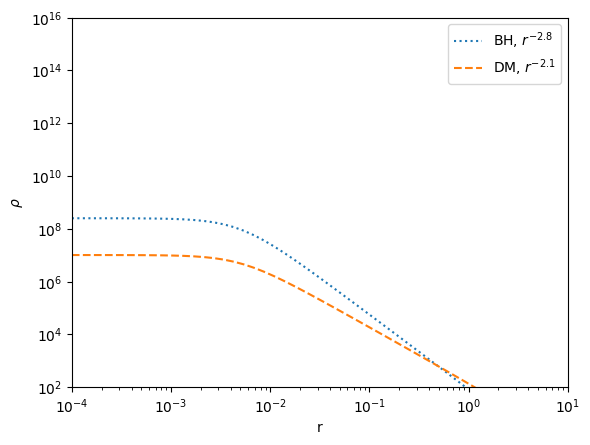

In [7]:
plot_densities(potential_bh.density, potential_dm.density)

### Let's focus on a BH model. Let's create a self-consistent model

In [8]:
def create_self_consistent_model(potential, df, verbose=False, plot=False):
    print("Creating a self-consistent model")
    dens = agama.Density(type="Plummer", mass=1.0, scaleRadius=1.0)

    # define the self-consistent model consisting of a single component
    params = dict(rminSph=0.001, rmaxSph=1000.0, sizeRadialSph=40, lmaxAngularSph=0)
    comp = agama.Component(df=df, density=dens, disklike=False, **params)
    scm = agama.SelfConsistentModel(**params)
    scm.components = [comp]

    # prepare visualization
    # r = np.logspace(-7.0, 7.0)
    r = np.logspace(-4.0, 1.0)
    xyz = np.vstack((r, r * 0, r * 0)).T
    if plot:
        plt.plot(r, dens.density(xyz), label="Init density")
        plt.plot(r, potential.density(xyz), label="True density", c="k")[0].set_dashes(
            [4, 4]
        )

    # perform several iterations of self-consistent modelling procedure
    for i in range(10):
        scm.iterate()
        if verbose:
            print(
                "Iteration %i, Phi(0)=%g, Mass=%g"
                % (i, scm.potential.potential(0, 0, 0), scm.potential.totalMass())
            )
        if plot:
            plt.plot(r, scm.potential.density(xyz), label="Iteration #" + str(i))

    # save the final density/potential profile
    scm.potential.export("simple_scm.ini")

    if plot:
        # show the results
        plt.legend(loc="lower left")
        plt.xlabel("r")
        plt.ylabel(r"$\rho$")
        plt.xscale("log")
        plt.yscale("log")
        plt.ylim(1e2, 1e16)
        plt.xlim(1e-4, 1e1)
        plt.show()

    return scm

Creating a self-consistent model
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...done
Updating potential...done
Updating action finder...done
Computing density for component 0...do

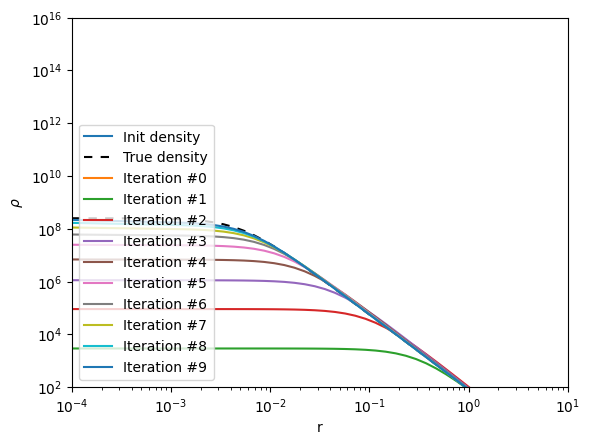

In [9]:
N = 10_000  # the number of simulated particles in a cluster

# create and write out an N−body realization of the model
scm = create_self_consistent_model(
    potential=potential_bh,
    df=df_bh,
    plot=True,
    verbose=False,
)

### Let's create a snapshot from self-consistent model and have a closer look on data

In [10]:
snap = agama.GalaxyModel(scm.potential, scm.potential.density).sample(N)
snap_xv, snap_m = snap
print(f"snap_xv shape: {snap_xv.shape}, snap_m shape {snap_m.shape}")

snap_xyz = snap_xv[:, :3]
print(f"Snap coordineate stats: Max={np.max(snap_xyz)}, Min={np.min(snap_xyz)}")

snap_vxvyvz = snap_xv[:, 3:]
print(f"Snap velocity stats: Max={np.max(snap_vxvyvz)}, Min={np.min(snap_vxvyvz)}")

snap_xv shape: (10000, 6), snap_m shape (10000,)
Snap coordineate stats: Max=4702.1917701276825, Min=-2594.9119413769986
Snap velocity stats: Max=20.568988111061337, Min=-20.284092950314157


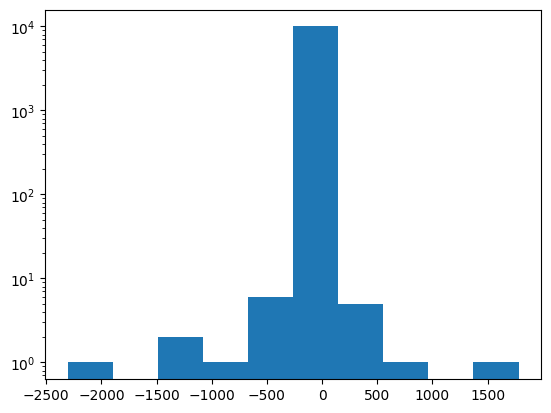

In [11]:
snap_x = snap_xyz[:, 0]
plt.hist(snap_x, log=True)
plt.yscale("log")

### Plot difference between self-consistent model density and real density

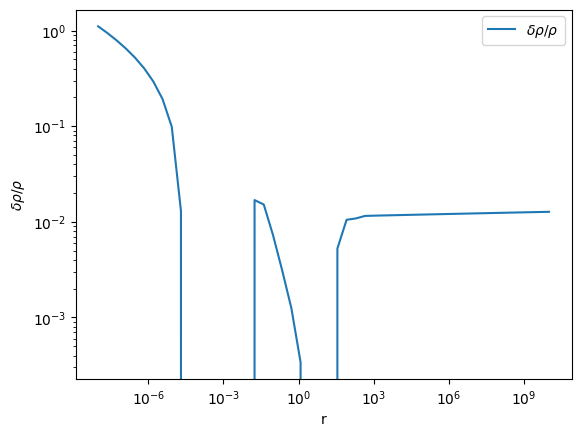

In [12]:
r = np.logspace(-8.0, 10.0)
xyz = np.vstack((r, r * 0, r * 0)).T

plt.plot(r, (scm.potential.density(xyz) - potential_bh.density(xyz)) / potential_bh.density(xyz), label=r"$\delta\rho / \rho$")

plt.legend(loc="upper right")
plt.xlabel("r")
plt.ylabel(r"$\delta\rho / \rho$")
plt.xscale("log")
plt.yscale("log")
plt.show()